In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
'''
import logging
tf.get_logger().setLevel(logging.ERROR)
'''
from glob import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

Using TensorFlow backend.


In [2]:
train_images = glob('kaggle/input/denoising-dirty-documents/train/*.png')
train_labels = glob('kaggle/input/denoising-dirty-documents/train_cleaned/*.png')
test_images = glob('kaggle/input/denoising-dirty-documents/test/*.png')
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


### Sample of train images and train labels

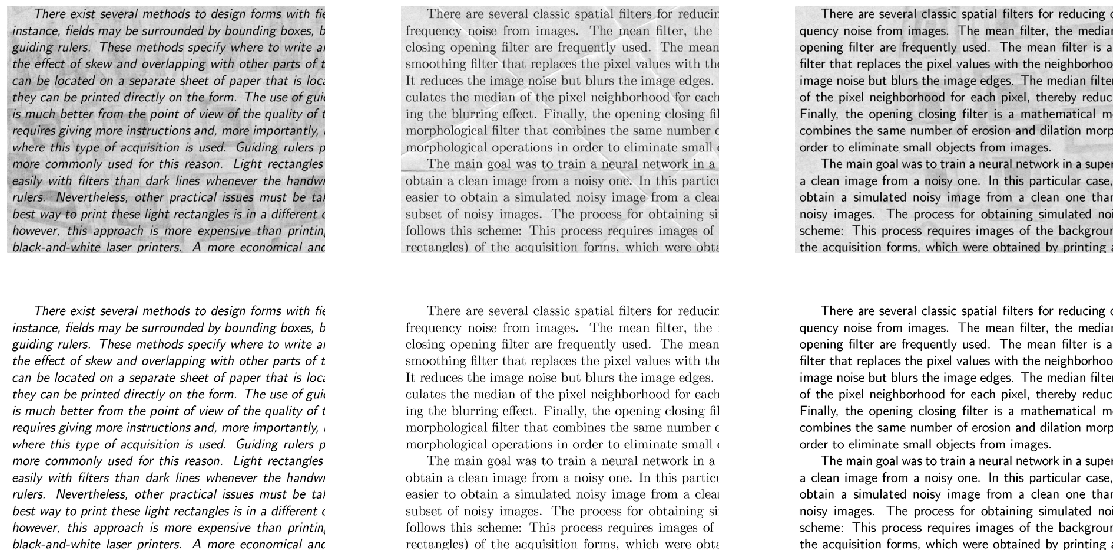

In [3]:
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2,3,figsize = (20,10))
for i, img in enumerate(samples):
    img = cv2.imread(img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()  

## CV2 Method

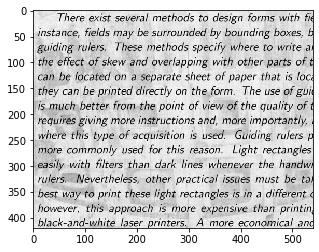

In [4]:
img = cv2.imread(train_images[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap = plt.cm.gray)
plt.show()

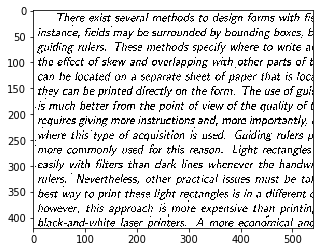

In [5]:
# applying different thresholding  
# techniques on the input image 
thresh1 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 30) 
plt.imshow(thresh1,cmap = plt.cm.gray) 
# plt.imshow(thresh2,cmap = plt.cm.gray) 
plt.show()

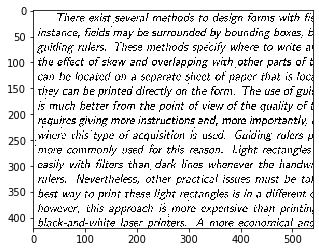

In [6]:
# applying different thresholding  
# techniques on the input image 
thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 25) 
plt.imshow(thresh2,cmap = plt.cm.gray) 
plt.show()

In [7]:
from PIL import Image
# cvt_image = cv2.cvtColor(thresh2, cv2.COLOR_GRAY2RGB)
im_pil = Image.fromarray(thresh2)
im_resized = im_pil.resize((540,420))
im_array = image.img_to_array(im_resized)

im_array.shape

(420, 540, 1)

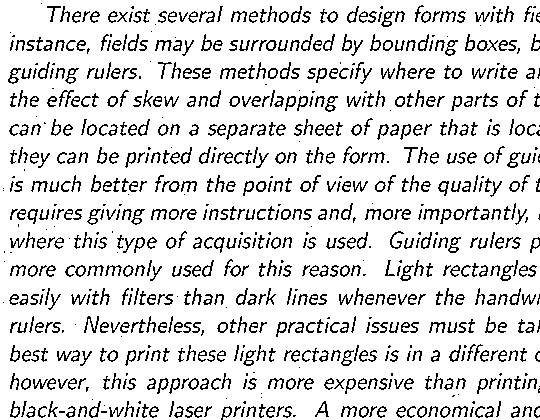

In [8]:
im_resized

In [9]:
proc_imgs = []
for k, figs in enumerate(zip(train_images, train_labels)):
    train_img = cv2.imread(figs[0], cv2.IMREAD_GRAYSCALE)
    proc_img = cv2.adaptiveThreshold(train_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 25)
    
    # cvt_image = cv2.cvtColor(proc_img, cv2.COLOR_GRAY2RGB)
    im_pil = Image.fromarray(proc_img)
    im_resized = im_pil.resize((540,420))
    # plt.imshow(im_resized,cmap=plt.cm.gray)
    # plt.show()
    im_array = image.img_to_array(im_resized).astype('float32')/255
    
    proc_imgs.append(im_array)

## AutoEncoder

In [10]:
def AutoEncoder():
    input_img = Input(shape=(420,540,1), name = 'input_image')
    
    # Encoder Layer
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    
    # Decoder
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = UpSampling2D((2,2), name='upsample3')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv3')(x)
    
    ae = Model(inputs=input_img, outputs=x)
    ae.compile(optimizer='Adagrad', loss='binary_crossentropy')
    return ae

In [11]:
ae = AutoEncoder()
ae.summary()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 32)      9248      
_________________________________________________________________
upsample3 (UpSampling2D)     (None, 420, 540, 32)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 420, 540, 1)       289       
Total params: 9,857
Trainable params: 9,8

In [12]:
X = []
Y = []

for img in train_images:
    img = image.load_img(img, color_mode='grayscale',target_size=(420,540))
    img = image.img_to_array(img).astype('float32')/255
    X.append(img)

for img in train_labels:
    img = image.load_img(img, color_mode='grayscale',target_size=(420,540))
    img = image.img_to_array(img).astype('float32')/255
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [13]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=100)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (115, 420, 540, 1)
Total number of validation samples:  (29, 420, 540, 1)


In [14]:
# Train your model
ae.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_valid, y_valid))




Train on 115 samples, validate on 29 samples
Epoch 1/30





115/115 [==============================] - 85s 736ms/step - loss: 0.3332 - val_loss: 0.2277
Epoch 2/30
115/115 [==============================] - 82s 714ms/step - loss: 0.1905 - val_loss: 0.1835
Epoch 3/30
115/115 [==============================] - 80s 696ms/step - loss: 0.1681 - val_loss: 0.1679
Epoch 4/30
115/115 [==============================] - 82s 716ms/step - loss: 0.1523 - val_loss: 0.1536
Epoch 5/30
115/115 [==============================] - 81s 708ms/step - loss: 0.1442 - val_loss: 0.1478
Epoch 6/30
115/115 [==============================] - 81s 706ms/step - loss: 0.1414 - val_loss: 0.1454
Epoch 7/30
115/115 [==============================] - 78s 679ms/step - loss: 0.1405 - val_loss: 0.1410
Epoch 8/30
115/115 [==============================] - 96s 838ms/step - loss: 0.1338 - val_loss: 0.1379
Epoch 9/30
115/115 [==============================] - 88s 764ms/step - loss: 0.1339 - val_loss: 0.1366
Epoch 10/30
115/115 

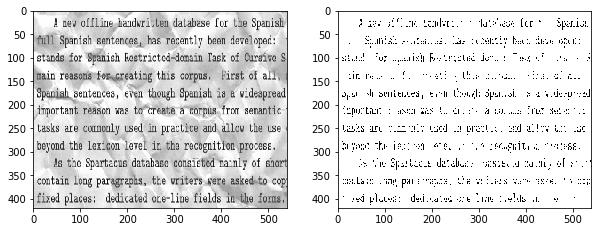

In [15]:
sample_test = image.load_img(test_images[10], color_mode='grayscale', target_size=(420,540))
sample_test = image.img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(ae.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()